## Introduction

This in-class example demonstrates how to calculate heteroskeasticity-robust standard error and conduct tests on the existence of heteroskedasticity.

What you need to know:  
- Statsmodels and pandas modules in python
- Theoretical concepts on time series regression model

The list of [references](#References) for detailed concepts and techniques used in this exerise.
***

## Content
- [Model a Time Trend](#Model-a-Time-Trend)
- [Static Housing Investment Model](#Estimate-a-Static-Housing-Investment-Model)
- [Static Housing Investment Model with Time Trend](#Estimate-a-Static-Housing-Investment-Model-with-Time-Trend)
- [Finite Distributed Lag Model](#Estimate-a-Finite-Distributed-Lag-Model) 
- [Finite Distributed Lag Model with Time Trend](#Estimate-a-Finite-Distributed-Lag-Model-with-Time-Trend)
- [References](#References)

***
## Data Description

The data set is contained in a comma-separated value (csv) file named ```HSEINV.csv``` with column headers. 

The data is a set of annual observations on housing investment and a housing price index in the United States for 1947 through 1988.

Description of the data is as follow:

| Name | Description |
| :--- | :--- |
| year     | 1947-1988 |
| inv      | real housing inv, millions $ |
| pop      | population, 1000s |
| price    | housing price index; 1982 = 1 |
| linv     | log(inv) |
| lpop     | log(pop) |
| lprice   | log(price) |
| t        | time trend: t = 1, ..., 42 |
| invpc    | per capita inv: inv/pop |
| linvpc   | log(invpc) |
| lprice_1 | lprice *last* period |
| linvpc_1 | linvpc *last* period |
| gprice   | lprice - lprice_1 |
| ginvpc   | linvpc - linvpc_1 |

***
## Load the required modules

In [195]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot

***
## Import the data set

#### Load the data set into Python

In [196]:
HSEINV = pd.read_csv("HSEINV.csv")
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  
0 -0.965831  
1 -0.817895  
2 -0.859694  
3 -0.567289  
4 -0.781643  


#### Sort the data in ascending order by year

In [197]:
HSEINV = HSEINV.sort_values(by=['year'])

#### Generate time index

Create new variable ```t``` such that $t=0$ in the first period 

In [198]:
HSEINV["t"] = HSEINV.year - HSEINV.year[0]
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  t  
0 -0.965831  0  
1 -0.817895  1  
2 -0.859694  2  
3 -0.567289  3  
4 -0.781643  4  


#### Generate lag variable

Create a new column in the date set named ```lprice_1```, such that $lprice\_1 = \log(price_{t-1})$ 

In [199]:
HSEINV["lprice_1"] = HSEINV.lprice.shift(1)
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  t  lprice_1  
0 -0.965831  0       NaN  
1 -0.817895  1 -0.199671  
2 -0.859694  2 -0.145141  
3 -0.567289  3 -0.167709  
4 -0.781643  4 -0.131819  


#### Generate "*first-differencing*" variables

Create a new column named ```gprice```, such that $gprice = \log(price_t) - \log(price_{t-1})$

In [200]:
HSEINV["gprice"] = HSEINV["lprice"] - HSEINV["lprice_1"]
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  t  lprice_1    gprice  
0 -0.965831  0       NaN       NaN  
1 -0.817895  1 -0.199671  0.054530  
2 -0.859694  2 -0.145141 -0.022567  
3 -0.567289  3 -0.167709  0.035890  
4 -0.781643  4 -0.131819  0.006142  


#### Compare the series of ```lprice``` with ```gprice``` 

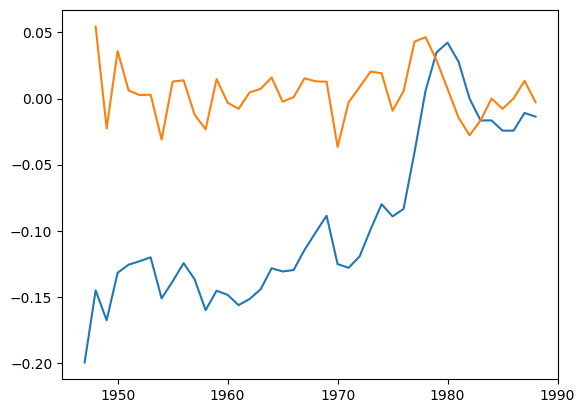

In [201]:
matplotlib.pyplot.plot(HSEINV.year,HSEINV.lprice)
matplotlib.pyplot.plot(HSEINV.year, HSEINV.gprice)

***
## Model a Time Trend

#### Estimate the time trend of log housing investment
$$linvpc = \beta_0 + \beta_1 t + u_t$$

In [202]:
model_t = smf.ols(formula='linvpc ~ year', data = HSEINV).fit()
print(model_t.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     20.19
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           5.85e-05
Time:                        16:43:03   Log-Likelihood:                 23.290
No. Observations:                  42   AIC:                            -42.58
Df Residuals:                      40   BIC:                            -39.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.6932      3.567     -4.680      0.0

#### Get the estimation results

How would you interpret $\beta_1$?

At 5% significance level, what would you conclude about $\beta_1$?

#### Plot the time series of log housing investment (predicted vs actual)

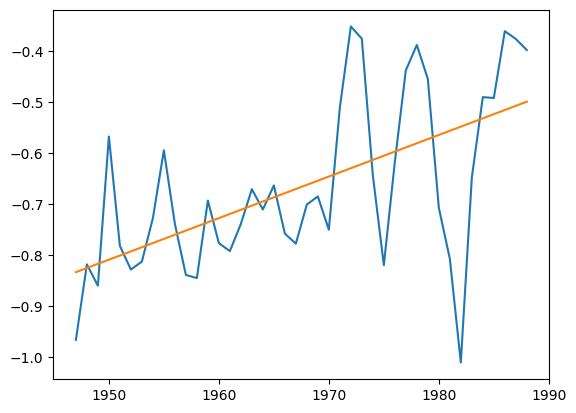

In [203]:
matplotlib.pyplot.plot(HSEINV.year, HSEINV.linvpc)
matplotlib.pyplot.plot(HSEINV.year, model_t.predict())

***
## Estimate a Static Housing Investment Model

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + u_t$$

#### Estimate the model

In [204]:
model_s = smf.ols(formula = "linvpc ~ lprice", data=HSEINV).fit()

#### Get the estimation results

In [205]:
print(model_s.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.53
Date:                Tue, 01 Apr 2025   Prob (F-statistic):            0.00238
Time:                        16:43:03   Log-Likelihood:                 19.617
No. Observations:                  42   AIC:                            -35.23
Df Residuals:                      40   BIC:                            -31.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5502      0.043    -12.788      0.0

How would you interpret $\beta_1$?

At 5% significance level, what would you conclude about $\beta_1$?

#### Plot the time series of log housing investment (predicted vs actual)

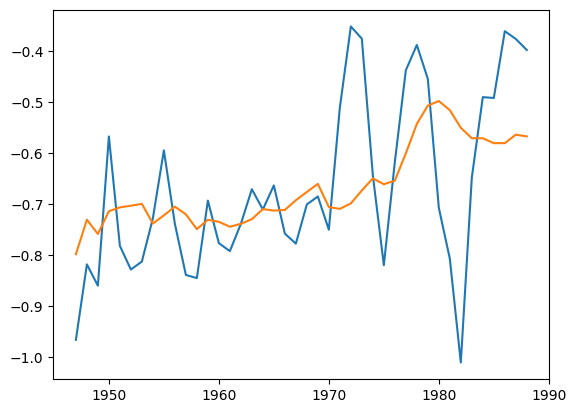

In [206]:
matplotlib.pyplot.plot(HSEINV.year, HSEINV.linvpc)
matplotlib.pyplot.plot(HSEINV.year, model_s.predict())

***
## Estimate a Static Housing Investment Model with Time Trend

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + \beta_2 t + u_t$$
where $t$ is the time trend.

#### Estimate the model

In [207]:
model_st = smf.ols(formula = "linvpc ~ lprice + t", data=HSEINV).fit()
print (model_st.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     10.08
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           0.000296
Time:                        16:43:03   Log-Likelihood:                 23.459
No. Observations:                  42   AIC:                            -40.92
Df Residuals:                      39   BIC:                            -35.71
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9032      0.132     -6.829      0.0

#### Get the estimation results

At 5% significance level, what would you conclude about $\beta_1$?

#### Plot the time series of log housing investment (predicted vs actual)

***
## Estimate a Finite Distributed Lag Model

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + \beta_2 lprice_{t-1} + u_t$$

#### Estimate the model

In [208]:
model_lag = smf.ols(formula = "linvpc ~ lprice + lprice_1", data=HSEINV).fit()

print(model_lag.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     8.893
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           0.000679
Time:                        16:43:03   Log-Likelihood:                 23.342
No. Observations:                  41   AIC:                            -40.68
Df Residuals:                      38   BIC:                            -35.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5821      0.041    -14.301      0.0

#### Get the estimation results

How would you interpret $\beta_1$?

How would you interpret $\beta_2$?

#### Plot the time series of log housing investment (predicted vs actual)

***
## Estimate a Finite Distributed Lag Model with Time Trend

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + \beta_2 lprice_{t-1} + t + u_t$$

#### Estimate the model

In [209]:
model_lagt = smf.ols(formula="linvpc ~ lprice + lprice_1 + t", data = HSEINV).fit()
print(model_lagt.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     15.96
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           8.09e-07
Time:                        16:43:04   Log-Likelihood:                 32.492
No. Observations:                  41   AIC:                            -56.98
Df Residuals:                      37   BIC:                            -50.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0730      0.113     -9.534      0.0

#### Get the estimation results

How would you interpret $\beta_1$?

How would you interpret $\beta_2$?

#### Plot the time series of log housing investment (predicted vs actual)

***
## References

- Jeffrey M. Wooldridge (2019). "Introductory Econometrics: A Modern Approach, 7e" Chapter 10.

- The pandas development team (2020). "[pandas-dev/pandas: Pandas](https://pandas.pydata.org/)." Zenodo.

- Seabold, Skipper, and Josef Perktold (2010). "[statsmodels: Econometric and statistical modeling with python](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)." Proceedings of the 9th Python in Science Conference.